<a href="https://colab.research.google.com/github/a-difazio/image-processing/blob/main/segmentazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path dei Dati

In [ ]:
import os

# imposto i path
base_path = 'drive/MyDrive/Training400'
image_path = os.path.join(base_path, 'images')
mask_path = os.path.join(base_path, 'masks')

# lista di immagini e maschere nello stesso ordine
image_paths = sorted([os.path.join(image_path, name) for name in os.listdir(image_path)])
mask_paths = sorted([os.path.join(mask_path, name) for name in os.listdir(mask_path)])

print(f'Numero di immagini: {len(image_paths)}')

Numero di immagini: 400


# Immagine di Esempio

Images Details
Image range 0-254
Image shape (2056, 2124, 3)
Image type uint8

Masks Details
Mask range 0-255
Mask shape (2056, 2124)
Mask type uint8



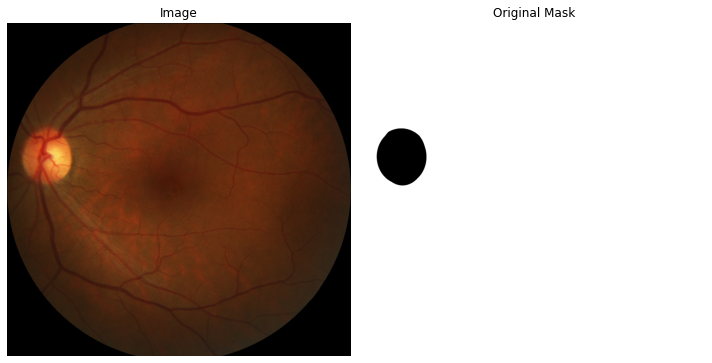

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

np.random.seed(10)
index = np.random.choice(len(image_paths))

image = imread(image_paths[index])
mask = imread(mask_paths[index])

print('Images Details')
print(f'Image range {image.min()}-{image.max()}')
print(f'Image shape {image.shape}')
print(f'Image type {image.dtype}\n')
print('Masks Details')
print(f'Mask range {mask.min()}-{mask.max()}')
print(f'Mask shape {mask.shape}')
print(f'Mask type {mask.dtype}\n')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(image)
ax[0].set_title('Image')
ax[0].set_axis_off()
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Original Mask')
ax[1].set_axis_off()
plt.tight_layout()

# Split del Dataset

In [ ]:
from sklearn.model_selection import train_test_split

full_train_img_path, test_img_path, full_train_mask_path, test_mask_path = train_test_split(image_paths, mask_paths, train_size=0.9, random_state=0)
train_img_path, val_img_path, train_mask_path, val_mask_path = train_test_split(full_train_img_path, full_train_mask_path, test_size=0.2, random_state=0)

# Funzioni per Caricamento e Preprocessing delle Immagini

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

# Dimensioni finali
HEIGHT = 256
WIDTH = 256

def read_images(paths):
  images = []
  for name in paths:
    image = imread(name)
    image = resize(image, (HEIGHT, WIDTH), anti_aliasing=False, order=0)
    images.append(image)

  return np.stack(images)

def read_masks(paths):
  masks = []
  for name in paths:
    mask = imread(name)
    mask = resize(mask, (HEIGHT, WIDTH), anti_aliasing=False, order=0)
    masks.append(np.expand_dims(mask, axis=-1))

  return np.stack(masks)


# Caricamento del Training Set

Images Details
Image range 0.0-1.0
Image shape (256, 256, 3)
Image type float64

Masks Details
Mask range 1.0-1.0
Mask shape (256, 256, 1)
Mask type float64



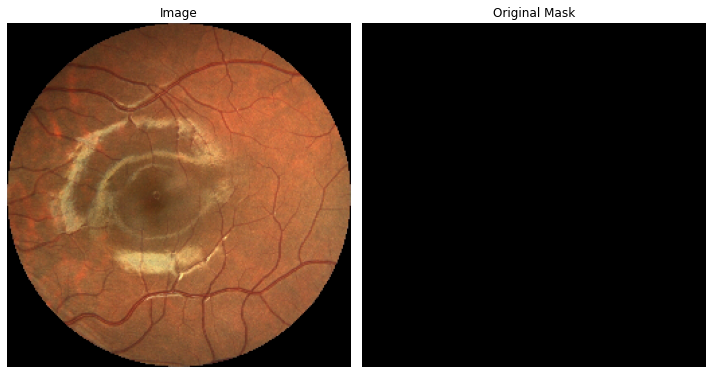

In [ ]:
train_img = read_images(train_img_path)
train_mask = read_masks(train_mask_path)

val_img = read_images(val_img_path)
val_mask = read_masks(val_mask_path)

# Con resize le immagine sono convertite in float64 con range 0-1
print('Images Details')
print(f'Image range {train_img[index].min()}-{train_img[index].max()}')
print(f'Image shape {train_img[index].shape}')
print(f'Image type {train_img[index].dtype}\n')
print('Masks Details')
print(f'Mask range {train_mask[index].min()}-{train_mask[index].max()}')
print(f'Mask shape {train_mask[index].shape}')
print(f'Mask type {train_mask[index].dtype}\n')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(train_img[index])
ax[0].set_title('Image')
ax[0].set_axis_off()
ax[1].imshow(np.squeeze(train_mask[index]), cmap='gray')
ax[1].set_title('Original Mask')
ax[1].set_axis_off()
plt.tight_layout()

# Definizione Dice Coefficient

In [ ]:
def dice(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return numerator / denominator

# Modello U-Net

In [ ]:
from tensorflow.keras import Model, layers
import tensorflow as tf

# Immagine di input (RGB)
CHANNELS = 3

tf.keras.backend.clear_session()

# Input
inputs = layers.Input((HEIGHT, WIDTH, CHANNELS))

# Encoder
conv_1 = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
conv_1 = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv_1)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

conv_2 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(pool_1)
conv_2 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv_2)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

conv_3 = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(pool_2)
conv_3 = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv_3)
pool_3 = layers.MaxPool2D(pool_size=(2, 2))(conv_3)

conv_4 = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(pool_3)
conv_4 = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv_4)
pool_4 = layers.MaxPool2D(pool_size=(2, 2))(conv_4)

conv_5 = layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(pool_4)
conv_5 = layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv_5)

# Decoder
up_6 = layers.Conv2DTranspose(filters=512, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv_5)
up_6 = layers.concatenate([up_6, conv_4])
conv_6 = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(up_6)
conv_6 = layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv_6)

up_7 = layers.Conv2DTranspose(filters=256, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv_6)
up_7 = layers.concatenate([up_7, conv_3])
conv_7 = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(up_7)
conv_7 = layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv_7)

up_8 = layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv_7)
up_8 = layers.concatenate([up_8, conv_2])
conv_8 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(up_8)
conv_8 = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv_8)

up_9 = layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv_8)
up_9 = layers.concatenate([up_9, conv_1])
conv_9 = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(up_9)
conv_9 = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(conv_9)

# Output
outputs = layers.Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='sigmoid')(conv_9)

# Modello
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# Visualizzazione Modello

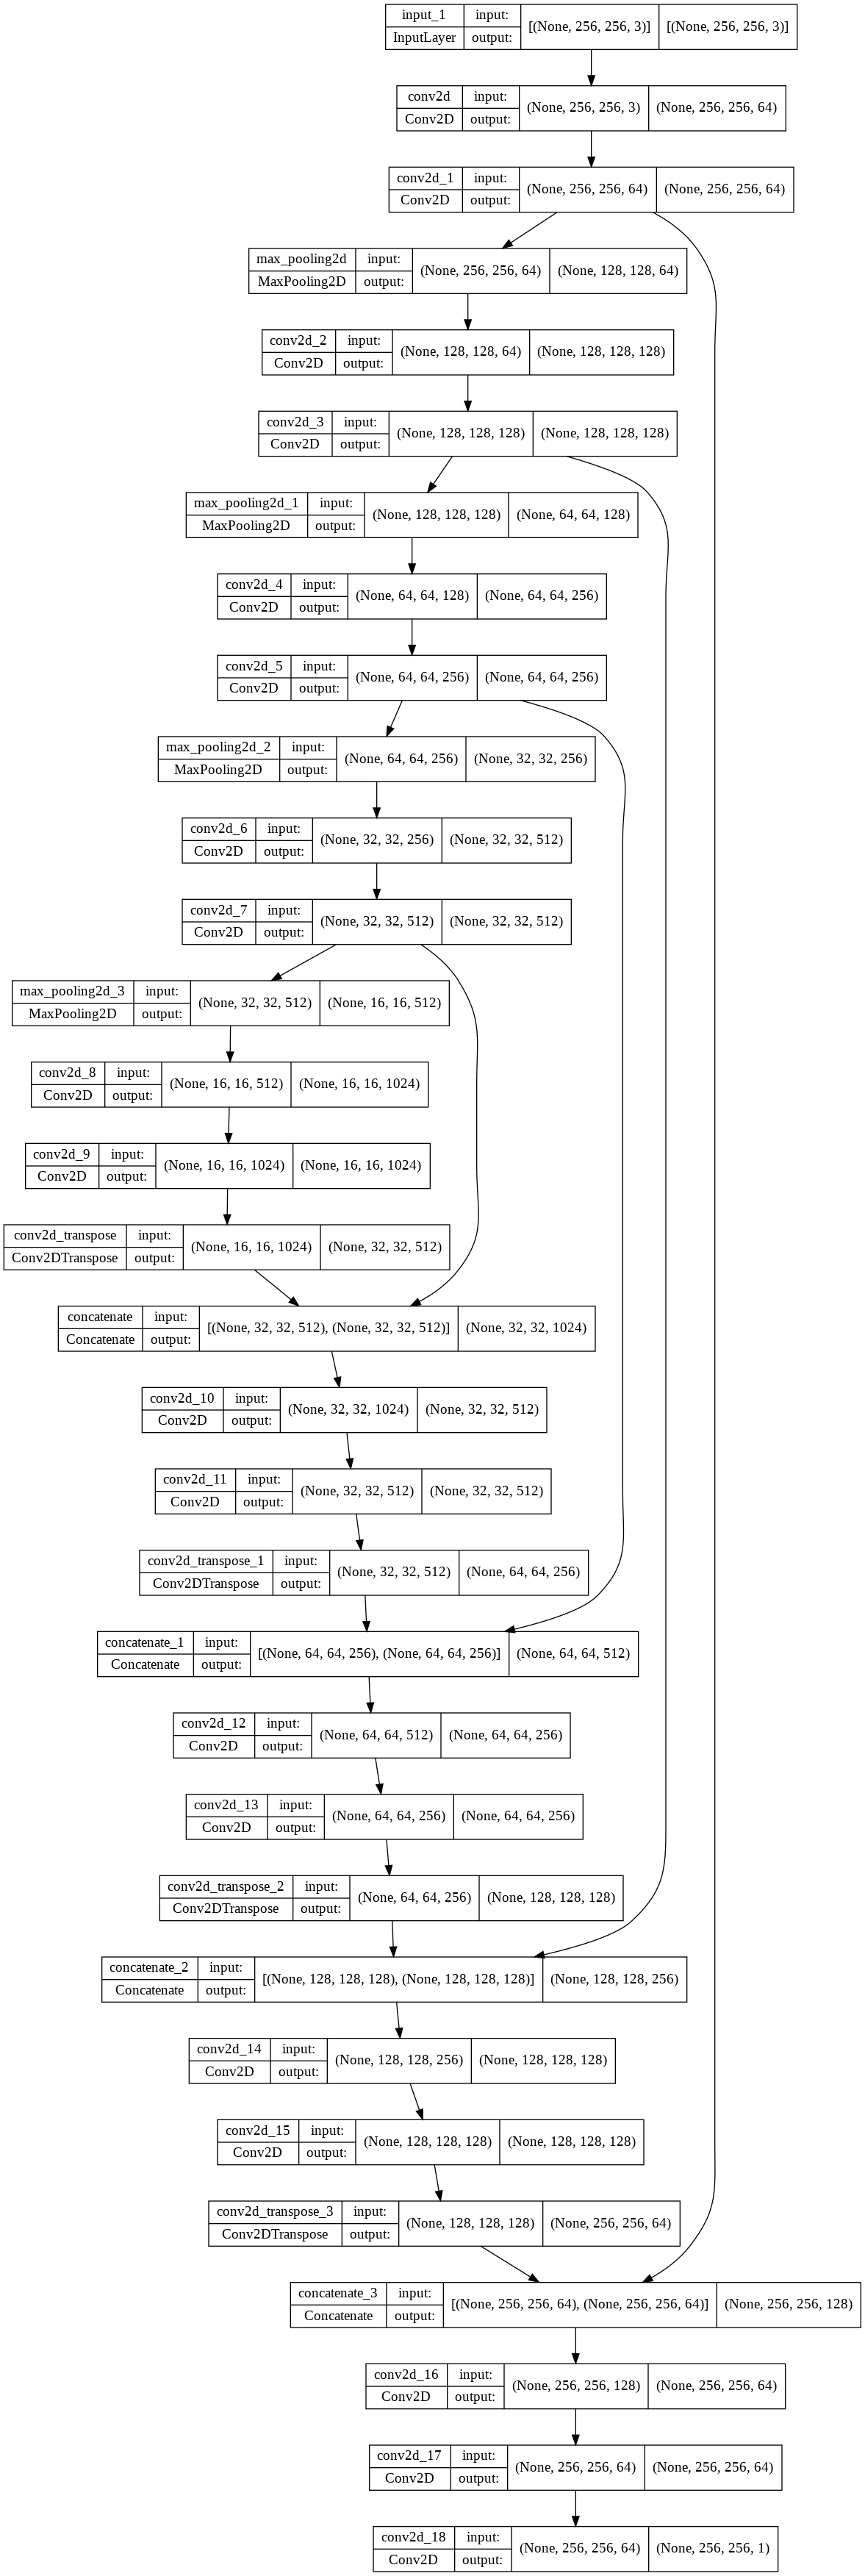

In [ ]:
from keras.utils.vis_utils import plot_model

model_plot_path = os.path.join(base_path, 'models', 'model_plot.png')
plot_model(model, to_file=model_plot_path, show_shapes=True, show_layer_names=True)

# Training del Modello

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True) 

unet = model.fit(train_img, train_mask, epochs=100, validation_data=(val_img, val_mask), batch_size=30, callbacks=[early_stop])

Epoch 1/100
10/10 [==============================] - 36s 3s/step - loss: 0.2614 - accuracy: 0.9877 - dice: 0.9012 - val_loss: 0.1017 - val_accuracy: 0.9880 - val_dice: 0.9741
Epoch 2/100
10/10 [==============================] - 32s 3s/step - loss: 0.0815 - accuracy: 0.9877 - dice: 0.9853 - val_loss: 0.0615 - val_accuracy: 0.9880 - val_dice: 0.9927
Epoch 3/100
10/10 [==============================] - 32s 3s/step - loss: 0.0513 - accuracy: 0.9877 - dice: 0.9901 - val_loss: 0.0383 - val_accuracy: 0.9880 - val_dice: 0.9900
Epoch 4/100
10/10 [==============================] - 32s 3s/step - loss: 0.0379 - accuracy: 0.9877 - dice: 0.9907 - val_loss: 0.0355 - val_accuracy: 0.9880 - val_dice: 0.9877
Epoch 5/100
10/10 [==============================] - 32s 3s/step - loss: 0.0354 - accuracy: 0.9877 - dice: 0.9903 - val_loss: 0.0292 - val_accuracy: 0.9880 - val_dice: 0.9923
Epoch 6/100
10/10 [==============================] - 32s 3s/step - loss: 0.0299 - accuracy: 0.9877 - dice: 0.9919 - val_loss:

# Curve di Apprendimento

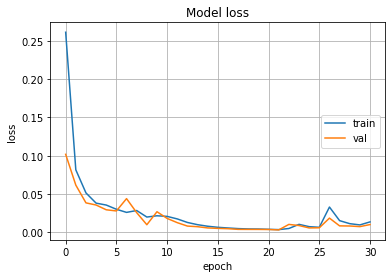

In [ ]:
plt.plot(unet.history['loss'])
plt.plot(unet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center right')
plt.grid(True)
plt.show()

# Salvataggio del Modello

In [ ]:
model_path = os.path.join(base_path, 'models', 'unet', 'unet.h5')
model.save(model_path)

# Caricamento del Modello

In [ ]:
from tensorflow.keras.models import load_model

model_path = os.path.join(base_path, 'models', 'unet', 'unet.h5')
model = load_model(model_path, custom_objects={"dice": dice})

# Caricamento del Test Set

In [ ]:
test_img = read_images(test_img_path)
test_mask = read_masks(test_mask_path)

preds = model.predict(test_img)

# Valutazione del Modello

In [ ]:
results = model.evaluate(test_img, test_mask)

2/2 [==============================] - 2s 375ms/step - loss: 0.0221 - accuracy: 0.9978 - dice: 0.9986


# Alcuni Esempi di Predizioni

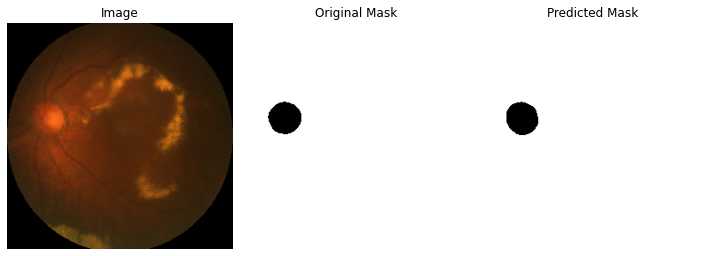

In [ ]:
index = 10

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
ax[0].imshow(test_img[index])
ax[0].set_title('Image')
ax[0].set_axis_off()
ax[1].imshow(np.squeeze(test_mask[index]), cmap='gray')
ax[1].set_title('Original Mask')
ax[1].set_axis_off()
pred_mask = np.squeeze(preds[index] >= 0.5)
ax[2].imshow(pred_mask, cmap='gray')
ax[2].set_title('Predicted Mask')
ax[2].set_axis_off()
plt.tight_layout()

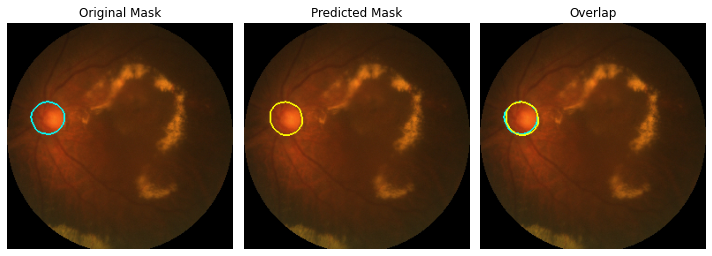

In [ ]:
from skimage.segmentation import mark_boundaries

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
original_boundaries = mark_boundaries(test_img[index], np.squeeze(test_mask[index]), color=(0, 1, 1), mode='thick') 
ax[0].imshow(original_boundaries)
ax[0].set_title('Original Mask')
ax[0].set_axis_off()
pred_boundaries = mark_boundaries(test_img[index], pred_mask, mode='thick')
ax[1].imshow(pred_boundaries)
ax[1].set_title('Predicted Mask')
ax[1].set_axis_off()
plt.tight_layout()
boundaries = mark_boundaries(original_boundaries, pred_mask, mode='thick')
ax[2].imshow(boundaries)
ax[2].set_title('Overlap')
ax[2].set_axis_off()
plt.tight_layout()